In [2]:
import sys
import math
import numpy as np
import pandas
import requests
import shutil
from fitparse import FitFile
import mediapipe as mp
import cv2
import trimesh
from trimesh.transformations import rotation_matrix
from pygltflib import GLTF2
import pyrender
import alphashape
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R

import SkeletonHelperGLTF

Joint names and indices:
DEF-breast.L: 197
DEF-breast.R: 199
DEF-foot.L: 90
DEF-foot.R: 109
DEF-forearm.L: 163
DEF-forearm.L.001: 162
DEF-forearm.R: 193
DEF-forearm.R.001: 192
DEF-hand.L: 161
DEF-hand.R: 191
DEF-pelvis.L: 44
DEF-pelvis.R: 46
DEF-shin.L: 92
DEF-shin.L.001: 91
DEF-shin.R: 111
DEF-shin.R.001: 110
DEF-shoulder.L: 149
DEF-shoulder.R: 179
DEF-spine: 36
DEF-spine.001: 35
DEF-spine.002: 34
DEF-spine.003: 33
DEF-spine.004: 32
DEF-spine.005: 31
DEF-spine.006: 30
DEF-thigh.L: 94
DEF-thigh.L.001: 93
DEF-thigh.R: 113
DEF-thigh.R.001: 112
DEF-toe.L: 89
DEF-toe.R: 108
DEF-upper_arm.L: 165
DEF-upper_arm.L.001: 164
DEF-upper_arm.R: 195
DEF-upper_arm.R.001: 194
MCH-ROT-head: 130
MCH-ROT-neck: 136
MCH-STR-neck: 134
MCH-WGT-chest: 207
MCH-WGT-hips: 118
MCH-foot_fk.L: 80
MCH-foot_fk.R: 99
MCH-foot_ik.parent.L: 235
MCH-foot_ik.parent.R: 249
MCH-foot_roll.L: 228
MCH-foot_roll.R: 242
MCH-foot_tweak.L: 51
MCH-foot_tweak.R: 65
MCH-forearm_ik.L: 155
MCH-forearm_ik.R: 185
MCH-forearm_tweak.L: 141

TODOS:
Load data: - Doneish
    Load Fit file as a list of dataframes - DONE
    Load metadata - Improve
        Replace hardcoded placeholder for mock metadata
        Generate a more elaborate metadata structure
    Load video - Elaborate
        Currently using a video key, maybe improve the way things are done
    Load full dataset - Improve
        Replace hardcoded strings to match the saving scheme
        Figure out the basic saving scheme for user data and metadata
        # TODO: get user key from connection request instead
        # TODO Later change to session date & time
    SessionData - Build up
        Improve SessionData to contain utility methods
        Rename SessionData as it means something slightly different in IT
        
Video correction - Doneish
    Load video - Improve
        Replace hardcoding with a dataset attribute
        Maybe save video to dataset as well?
        Or add the functions as utility for later caching?
    Load camera matrix - Implement
        Store the camera matrix properly in the metadata
        Currently using good enough mock matrix for correction (works suprisingly well)
        Add a fallback to using the default matrix if camera is uncallibrated
    Camera matrix - Build up
        Add helper methods to save and read from metadata
    Correct video - Clean
        Code works and did not have any notes, but the method is tad long and would benefit from a second look

Getting pose - Doneish
    Get pose - Elaborate & clean
        The method works okay for a prototype, but it has a few issues
        First, since the video is closed after calling it, it fails after executing once without reopening and recorrecting the video.
        This indicates that maybe the workflow should be improved in relation to working with video
        Also, did not test out visualization yet

Converting pose to a 3d points skeleton (To be fair, this should be - convert from third party pose to our 'simpified' model (33 3D point list)) - Implement conversion to 3D
    Unit vector extraction - Finish implementation and Test 
        ExtractCoords - Improve
            verify if using a list of pose_landmarks (point list) is the best way of doing this
        LoadCameraFrame - Implement
        PointsToUnitVectors - Improve
            camera frame is unused
    Conversion to 3D - Implement

Pose to area - Implement FitMesh from ChatGPT (This then is a method for getting area from pose. That said, in some cases pose could be skipped, but then two previous steps are just a tad different and this could be seen as video to 2d area shape (and this could differ based on the calculator used, as some sims may use a 3d surface for CdA) in the end, pose gets the riders
configuration, while pose to area combines the riders model with the configuration to generate an avatar (a digital twin) for CdA calculation purposes)
    Mesh import - Finish implementation and Test
        Create/Find mock rider mesh
        Get rider mesh - Test
    FitMesh - Implement
    Create wind planes - Elaborate
    Project to plane - Test & improve

Calculate results - Doneish, Waiting for testing
    Get area - Test & Improve
        Throw exception on multishape
    Calculate .. - Test & Improve math
        Get accurate coeficients (from metadata?)
    Calculate results - Test & Improve
        Zip metadata
        Create mock metadata for velocity
        Check how to best tie together fit data with video data (timestamps?)        

# Load data

In [3]:
class SessionData:
    def __init__(self, video_key, fit_data, metadata):
        self.video_key = video_key
        self.fit_data = fit_data
        self.metadata = metadata
        self.name = metadata['name']

In [4]:
def load_fit_file(file_name, file_path, backup_data=False):
    """
    Load a FIT file and return the data as a pandas DataFrame.
    """
    fitfile = FitFile(file_path+file_name)

    data = {}
    unique_msg = set()
    for msg in fitfile.get_messages():
        unique_msg.add(msg.name)

    for table_name in unique_msg:
        table_list = []
        for table in fitfile.get_messages(table_name):
            table_data = {}
            for field in table:
                table_data[field.name] = field.value
            table_list.append(table_data)
        data[table_name] = pandas.DataFrame(table_list)

    if backup_data:
        for table_name, df in data.items():
            file_name = f"{file_name}_{table_name}.csv"
            df.to_csv(file_name, index=False)
    return data

In [5]:
fit_data = load_fit_file("Freezing_Pain.fit", "data/raw/")

print(type(fit_data))
print(type(fit_data.keys()))
print(type(fit_data.values()))
print(type(fit_data['record']))
print(fit_data['record'].head(5))
print(fit_data['record'].sample(5))

<class 'dict'>
<class 'dict_keys'>
<class 'dict_values'>
<class 'pandas.core.frame.DataFrame'>
   altitude  cadence  distance  enhanced_altitude  enhanced_speed  heart_rate  \
0      -1.0       71       6.1               -1.0           0.000         122   
1      -1.0       71       9.3               -1.0           0.000         122   
2      -1.0       71      12.4               -1.0           3.150         122   
3      -3.4       78      19.0               -3.4           4.300         122   
4      -3.4       82      25.6               -3.4           4.875         123   

   position_lat  position_long  power  speed  temperature           timestamp  
0     675960302      282546511  205.0  0.000           11 2025-03-11 14:23:18  
1     675960302      282546511  249.0  0.000           11 2025-03-11 14:23:19  
2     675960302      282546511  214.0  3.150           11 2025-03-11 14:23:20  
3     675959824      282545628  200.0  4.300           11 2025-03-11 14:23:21  
4     675959288   

In [6]:
fitfile = FitFile('data/raw/Freezing_Pain.fit')

for msg in fitfile.get_messages():
    if(msg.name != 'record'):
        print(msg.name)

print(type(fitfile))
print(type(fitfile.messages))
print(type(fitfile.messages[0]))
print(type(fitfile.messages[0].fields))
print(type(fitfile.messages[0].fields[0]))
print(type(fitfile.get_messages('lap')))
print(type(fitfile.get_messages('record')))
print(type(fitfile.parse()))
print(fitfile.parse())

for lap in fitfile.get_messages('lap'):  # 'record' messages contain the actual data points
    # Each lap has multiple data fields
    lap_data = {}
    for data in lap:
        lap_data[data.name] = data.value

    print(lap_data)

# Iterate through all records and print data
for record in fitfile.get_messages('record'):  # 'record' messages contain the actual data points

    # Each record has multiple data fields
    record_data = {}
    for data in record:
        record_data[data.name] = data.value

    print(record_data)

file_id
file_creator
user_profile
event
lap
lap
lap
lap
lap
lap
lap
lap
lap
lap
event
session
activity
<class 'fitparse.base.FitFile'>
<class 'list'>
<class 'fitparse.records.DataMessage'>
<class 'list'>
<class 'fitparse.records.FieldData'>
<class 'generator'>
<class 'generator'>


AttributeError: 'NoneType' object has no attribute 'tell'

In [7]:
# Create mock data
# Create mock metadata
metadata = {
    'name': 'Freezing Pain',
    'description': 'A session of freezing pain',
    'date': '2023-10-01',
    'location': 'Unknown',
    'duration': 3600,
    'calories': 500,
}
df_proto = [metadata]
df = pandas.DataFrame(df_proto)
df.to_csv('data/raw/metadata.csv', index=False)

In [5]:
def load_metadata(user_key, data_path):
    """
    Load metadata from a CSV file.
    """
    metadata = pandas.read_csv(data_path + "metadata.csv" )#(user_key)
    return metadata

In [6]:
def get_user_key_meta_data(fit_data):
    """
    Get user key meta data from the database.
    """
    return fit_data["user_profile"]["friendly_name"]
    

In [7]:
def load_dataset(data_path, session_id=None):
    if session_id is None:
        session_id = "Freezing_Pain" # TODO Later change to session date & time
    # load video key or full video
    video_key = data_path.split('/')[-1].split('.')[0]
    # load fit file
    fit_data = load_fit_file(session_id + ".fit", data_path)
    # load user metadata
    meta_data = load_metadata(get_user_key_meta_data(fit_data), data_path) # TODO: get user key from connection request instead
    # convert it into our dataset
    dataset = SessionData(video_key, fit_data, meta_data)
    return dataset

In [11]:
data_path = "data/ride1/"
session_id = "Afternoon_Ride"

In [12]:
data_key = sys.argv[1]
# DB = db_pck.load_db(env_var_db_path)
# data_path = load_path(DB.fetch_path(data_key))

dataset = load_dataset(data_path, session_id)

In [13]:
for key in dataset.fit_data:
    dataset.fit_data[key].to_csv(f'data/raw/{session_id}_{key}.csv', index=False)

In [14]:
print(type(dataset.video_key))
print(type(dataset.fit_data))
print(type(dataset.metadata))

<class 'str'>
<class 'dict'>
<class 'pandas.core.frame.DataFrame'>


# Fisheye correction

In [8]:
class CameraMatrix:
    def __init__(self, K, D):
        self.K = K
        self.D = D

    def project(self, points):
        # Dummy projection function
        return points

    def unproject(self, points):
        # Dummy unprojection function
        return points

In [9]:
def LoadCameraMatrix(data_path):
    K = np.array([
        [320.0,   0.0, 320.0],  # fx, 0, cx
        [  0.0, 320.0, 240.0],  # 0, fy, cy
        [  0.0,   0.0,   1.0]
    ])
    D = np.array([[-0.18], [0.03], [0.0], [0.0]])
    cam_matrix = CameraMatrix(K,D)
    return cam_matrix

In [10]:
def CorrectImageDistortion(cam_matrix, image, width, height):
    # Dummy distortion correction function
    K = cam_matrix.K
    D = cam_matrix.D
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (width, height), None)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (width, height), cv2.CV_16SC2)
    undistorted_frame = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR)
    return undistorted_frame

In [11]:
def CorrectImageDistortionLite(image, map1, map2):
    undistorted_frame = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR)
    return undistorted_frame

In [186]:
def CorrectVideo(cap, camera_matrix, output_path="./output/output.mp4", show_output = False, start_time=0, end_time=40): #video
    K = camera_matrix.K
    D = camera_matrix.D
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Convert times to frame indices
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    end_frame = min(end_frame, total_frames)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (width, height), None)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (width, height), cv2.CV_16SC2)
    cnt = 0
    while cap.isOpened() and cnt < (end_frame-start_frame)*fps:
        ret, frame = cap.read()
        if not ret:
            break

        # Undistort the frame using the precomputed maps
        undistorted_frame = CorrectImageDistortionLite(frame, map1, map2)

        if show_output:
        # Show the frame (optional)
            cv2.imshow("Undistorted Video", undistorted_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Write to output file
        
        out.write(undistorted_frame)
        cnt += 1

    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    c_video = cv2.VideoCapture(output_path)
    return c_video
    

In [ ]:
# Mediapose stopgap code
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1746607180.285077 1225256 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746607180.303881 1544395 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4060)


W0000 00:00:1746607180.393647 1544382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746607180.442620 1544389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [192]:
#video = cv2.VideoCapture(data_path + "video/"+ "cycle_demo.mp4")        #dataset.GetVideo()
video = cv2.VideoCapture("data/ride1/video/IPS_2025-04-15.13.33.29.4630-002.mp4") 
camera_matrix = LoadCameraMatrix(data_path + "/camera_matrix") # dataset.meta.camera_matrix
c_video = CorrectVideo(video, camera_matrix)
print(c_video)

< cv2.VideoCapture 0x7f9cecd35a90>


# Pose extraction

In [13]:
def GetFramePose(image, pose):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Process the image and get the pose landmarks
    results = pose.process(image_rgb)
    return results

In [190]:
# TODO: add intermediate video capture
def GetPose(c_video, show_output=False,output_path="./output/output_pose.mp4", start_time=0, end_time=9):
    result_list = []
    width = int(c_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(c_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Convert times to frame indices
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    end_frame = min(end_frame, total_frames)
    c_video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    cnt = 0
    while c_video.isOpened() and cnt < (end_frame-start_frame)*fps:
        ret, frame = c_video.read()
        if not ret:
            break

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame with MediaPipe Pose
        results = pose.process(rgb_frame)

        # Draw pose landmarks on the frame
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
            )
        
        result_list.append(results) #check if deep copy needed

        # Display the frame
        if show_output:
            cv2.imshow('MediaPipe Pose', frame)
            # Exit loop on pressing 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        if out is not None:
            # Write the frame to the output video
            out.write(frame)
        cnt += 1

    c_video.release()
    out.release()
    cv2.destroyAllWindows()
    return result_list

In [ ]:
# Mediapipe stopgap code
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe Pose
    results = pose.process(rgb_frame)

    # Draw pose landmarks on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
        )

    # Display the frame
    cv2.imshow('MediaPipe Pose', frame)

    # Exit loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

In [191]:
pose_info = GetPose(c_video, show_output=True) #GetPose(c_video)
print(type(pose_info))
print(pose_info)


<class 'list'>
[]


In [25]:
print(type(pose_info[0]))
print(type(pose_info[0].pose_landmarks))
print(type(pose_info[0].pose_landmarks.landmark))
print(type(pose_info[0]))
print(pose_info[0].pose_landmarks.landmark)
print(type(pose_info[0].pose_landmarks.landmark))

<class 'type'>
<class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
<class 'google._upb._message.RepeatedCompositeContainer'>
<class 'type'>
[x: 0.422408581
y: 0.138015613
z: -0.486073583
visibility: 0.999927878
, x: 0.432492167
y: 0.0992877483
z: -0.473404974
visibility: 0.999850273
, x: 0.440512717
y: 0.0975428522
z: -0.473418623
visibility: 0.99981457
, x: 0.44799608
y: 0.0960707
z: -0.473492324
visibility: 0.999841094
, x: 0.399934143
y: 0.104568094
z: -0.475177944
visibility: 0.999726593
, x: 0.390276372
y: 0.106092006
z: -0.475209296
visibility: 0.999633074
, x: 0.382227451
y: 0.107128412
z: -0.475250244
visibility: 0.999619126
, x: 0.459539831
y: 0.101796716
z: -0.344902277
visibility: 0.999815762
, x: 0.37091431
y: 0.115304977
z: -0.356209606
visibility: 0.99919945
, x: 0.440815121
y: 0.159771234
z: -0.433554351
visibility: 0.999922395
, x: 0.412032306
y: 0.169854432
z: -0.436514467
visibility: 0.999881268
, x: 0.514167905
y: 0.219854921
z: -0.25668785
visi

# Unit vector extraction

In [15]:
def ExtractPointsFromLandmarks(pose):
    points = []
    try:
        for el in enumerate(pose.pose_landmarks.landmark):
            points.append([el[1].x, el[1].y])
    except:
        print(f"Error extracting points from landmarks")
        return np.zeros((33, 2))
    return np.array(points)

In [16]:
def ExtractPoints(pose_info):
    points2d = []
    err_counter = 0
    for frame in pose_info:
        points2d.append(ExtractPointsFromLandmarks(frame))
    return np.array(points2d)

In [17]:
def PointsToUnitVectors(points, camera_frame):
    ones = np.ones((points.shape[0], 1))
    direction_vectors = np.hstack((points.reshape(-1, 2), ones))
    direction_vectors /= np.linalg.norm(direction_vectors, axis=1, keepdims=True)
    return direction_vectors

In [18]:
def PointListToUnitVectors(frames, camera_frame):
    unit_vectors = []
    for frame in frames:
        unit_vectors.append(PointsToUnitVectors(frame, camera_frame))
    return np.array(unit_vectors)

In [19]:
def LoadCameraFrame(data_path): #loads a camera reference frame, used to convert local coordinates to global coordinates
    pass

In [20]:
points2D = ExtractPoints(pose_info)
camera_frame = LoadCameraFrame(data_path + "/camera_matrix") #dataset.meta.camera_frame
unit_vectors = PointListToUnitVectors(points2D, [])# dataset.meta.camera_frame)

NameError: name 'pose_info' is not defined

# Conversion to 3D

In [21]:
def calculate_camera_distance(coords_start, coords_end, image_width=None, image_height=None, pixel_coords=False):
    """Compute Euclidean distance between two landmarks."""
    if pixel_coords and image_width and image_height:
        x1, y1 = coords_start.x * image_width, coords_start.y * image_height
        x2, y2 = coords_end.x * image_width, coords_end.y * image_height
    else:
        x1, y1 = coords_start.x, coords_start.y
        x2, y2 = coords_end.x, coords_end.y

    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [22]:
def GetPoseSegments():
    POSE_SEGMENTS = {
    # Head and Torso
    "head_to_shoulders": (0, 11),       # Nose to Left Shoulder
    "shoulders": (11, 12),              # Left Shoulder to Right Shoulder
    "torso": (23, 24),                  # Left Hip to Right Hip
    "spine_left": (11, 23),            # Left Shoulder to Left Hip
    "spine_right": (12, 24),            # Right Shoulder to Right Hip

    # Left Arm
    "left_upper_arm": (11, 13),         # Shoulder to Elbow
    "left_forearm": (13, 15),           # Elbow to Wrist
    "left_hand_index": (15, 19),        # Wrist to Index Finger Tip
    "left_hand_thumb": (15, 21),        # Wrist to Thumb Tip

    # Right Arm
    "right_upper_arm": (12, 14),        # Shoulder to Elbow
    "right_forearm": (14, 16),          # Elbow to Wrist
    "right_hand_index": (16, 20),       # Wrist to Index Finger Tip
    "right_hand_thumb": (16, 22),       # Wrist to Thumb Tip

    # Left Leg
    "left_thigh": (23, 25),             # Hip to Knee
    "left_shin": (25, 27),              # Knee to Ankle
    "left_foot": (27, 31),              # Ankle to Foot Index (toe)

    # Right Leg
    "right_thigh": (24, 26),            # Hip to Knee
    "right_shin": (26, 28),             # Knee to Ankle
    "right_foot": (28, 32),             # Ankle to Foot Index (toe)
    }
    return POSE_SEGMENTS

In [23]:
def LeastSquares(unit_vectors, point_distance_pairs):
    POSE_SEGMENTS = GetPoseSegments()
    # calculate distances between point pairs
    distances = {}
    #for segment, (start, end) in POSE_SEGMENTS.items():
    #    distances[segment] = calculate_camera_distance(pose[start], pose[end])
    
    # least squares fitting
    def error_function(X):
        X = X.reshape(-1, 3)  # Reshape to (N, 3)
        errors = []
        for key, d_ij in point_distance_pairs.items():
            i,j  = POSE_SEGMENTS[key]
            dist = np.linalg.norm(X[i] - X[j])  # Euclidean distance
            errors.append(dist - d_ij)  # Difference from known distance
        return errors

    # Initial guess: Assume all points lie along their respective unit vectors, scaled
    initial_guess = unit_vectors * 2.0  # Arbitrary scale

    # Solve using least squares optimization
    result = least_squares(error_function, initial_guess.ravel())

    # Extract optimized 3D points
    reconstructed_points = result.x.reshape(-1, 3)
    #print("Reconstructed 3D Points:\n", reconstructed_points)

    return reconstructed_points

In [24]:
def GetConstPairs(data_path):
    # TODO get pairs from metadata
    pairs = {
    # Head and Torso
    "head_to_shoulders": 0.2,       # Nose to Left Shoulder
    "shoulders": 0.34,              # Left Shoulder to Right Shoulder
    "torso": 0.32,                  # Left Hip to Right Hip
    "spine_left": 0.50,            # Left Shoulder to Left Hip
    "spine_right": 0.52,            # Right Shoulder to Right Hip

    # Left Arm
    "left_upper_arm": 0.3,         # Shoulder to Elbow
    "left_forearm": 0.18,           # Elbow to Wrist
    "left_hand_index": 0.10,        # Wrist to Index Finger Tip
    "left_hand_thumb": 0.08,        # Wrist to Thumb Tip

    # Right Arm
    "right_upper_arm": 0.3,        # Shoulder to Elbow
    "right_forearm": 0.18,          # Elbow to Wrist
    "right_hand_index": 0.10,       # Wrist to Index Finger Tip
    "right_hand_thumb": 0.08,       # Wrist to Thumb Tip

    # Left Leg
    "left_thigh": 0.50,             # Hip to Knee
    "left_shin": 0.35,              # Knee to Ankle
    "left_foot": 0.2,              # Ankle to Foot Index (toe)

    # Right Leg
    "right_thigh": 0.5,            # Hip to Knee
    "right_shin": 0.35,             # Knee to Ankle
    "right_foot": 0.2,             # Ankle to Foot Index (toe)
    }

    return pairs

In [25]:
def LeastSquaresArray(unit_vector_frames, const_pairs):
    points3D_ = []
    for unit_vectors in unit_vector_frames:
        points3D_.append(LeastSquares(unit_vectors, const_pairs))
    return np.array(points3D_)

In [37]:
const_pairs = GetConstPairs(data_path + "/rider_keypointpairs") #dataset.meta.rider_info.GetConstPairs()
points3D = LeastSquaresArray(unit_vectors, const_pairs)

In [38]:
def Save3DPoints(points3D, output_path):
    # Save the 3D points to a CSV file
    tuple_array = points3D.tolist()
    points_df = pandas.DataFrame(tuple_array, columns=[f'keypoint_{i}' for i in range(33)])
    print(points_df.shape)
    points_df.to_csv(output_path, index=False)
    print(f"3D points saved to {output_path}")

In [39]:
Save3DPoints(points3D, "data/ride1/3D_points.csv")
print(type(points3D))
print(type(points3D[0]))
print(points3D[0].shape)
print(points3D[0])

(3456, 33)
3D points saved to data/ride1/3D_points.csv
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(33, 3)
[[0.73373793 0.19798252 1.85625191]
 [0.79063847 0.18150783 1.82809894]
 [0.80307014 0.17782404 1.82303509]
 [0.81456187 0.17467905 1.81823436]
 [0.73919998 0.19327365 1.84830427]
 [0.72361203 0.19670535 1.85410157]
 [0.71052183 0.19914079 1.85889797]
 [0.83157114 0.18420865 1.8095736 ]
 [0.69149644 0.21496334 1.8643024 ]
 [0.79824129 0.28931856 1.81083009]
 [0.75269719 0.31028867 1.82679169]
 [0.91263208 0.24262569 1.77876727]
 [0.60014375 0.20246426 1.90658784]
 [0.88302311 0.53266141 1.7080383 ]
 [0.45749278 0.46605196 1.91971113]
 [0.82602068 0.69756916 1.66380981]
 [0.48834123 0.60779774 1.81314422]
 [0.83131454 0.83694549 1.61506606]
 [0.40470379 0.74723724 1.81048373]
 [0.82894024 0.79374049 1.63656003]
 [0.45795948 0.70301495 1.8164049 ]
 [0.83318951 0.77449303 1.64304143]
 [0.4854202  0.68758164 1.81824286]
 [0.86143019 0.73926258 1.7517457 ]
 [0.58600821 0.72222247 1

In [26]:
import SkeletonHelperGLTF

In [41]:
SkeletonHelperGLTF.test_skeleton_helper()

Joint names and indices:
DEF-breast.L: 197
DEF-breast.R: 199
DEF-foot.L: 90
DEF-foot.R: 109
DEF-forearm.L: 163
DEF-forearm.L.001: 162
DEF-forearm.R: 193
DEF-forearm.R.001: 192
DEF-hand.L: 161
DEF-hand.R: 191
DEF-pelvis.L: 44
DEF-pelvis.R: 46
DEF-shin.L: 92
DEF-shin.L.001: 91
DEF-shin.R: 111
DEF-shin.R.001: 110
DEF-shoulder.L: 149
DEF-shoulder.R: 179
DEF-spine: 36
DEF-spine.001: 35
DEF-spine.002: 34
DEF-spine.003: 33
DEF-spine.004: 32
DEF-spine.005: 31
DEF-spine.006: 30
DEF-thigh.L: 94
DEF-thigh.L.001: 93
DEF-thigh.R: 113
DEF-thigh.R.001: 112
DEF-toe.L: 89
DEF-toe.R: 108
DEF-upper_arm.L: 165
DEF-upper_arm.L.001: 164
DEF-upper_arm.R: 195
DEF-upper_arm.R.001: 194
MCH-ROT-head: 130
MCH-ROT-neck: 136
MCH-STR-neck: 134
MCH-WGT-chest: 207
MCH-WGT-hips: 118
MCH-foot_fk.L: 80
MCH-foot_fk.R: 99
MCH-foot_ik.parent.L: 235
MCH-foot_ik.parent.R: 249
MCH-foot_roll.L: 228
MCH-foot_roll.R: 242
MCH-foot_tweak.L: 51
MCH-foot_tweak.R: 65
MCH-forearm_ik.L: 155
MCH-forearm_ik.R: 185
MCH-forearm_tweak.L: 141

# Points to Area

In [27]:
def compute_bone_transform(p1, p2):
    """Returns rotation matrix to align bone with direction p1 → p2"""
    direction = np.array(p2) - np.array(p1)
    direction /= np.linalg.norm(direction)
    # Assume rest pose is along +Y, compute rotation to match
    rot, _ = R.align_vectors([direction], [[0, 1, 0]])
    return rot.as_matrix()

In [28]:
def GetKeypointNames():
    keypoints = {
    "nose": 0,                      # Nose to Left Shoulder
    "left_eye_inner": 1,           # Left Eye Inner
    "left_eye": 2,                 # Left Eye
    "left_eye_outer": 3,           # Left Eye Outer
    "right_eye_inner": 4,          # Right Eye Inner
    "right_eye": 5,                # Right Eye
    "right_eye_outer": 6,          # Right Eye Outer
    "left_ear": 7,                 # Left Ear
    "right_ear": 8,                # Right Ear
    "mouth_left": 9,               # Mouth Left
    "mouth_right": 10,             # Mouth Right
    "left_shoulder": 11,           # Left Shoulder
    "right_shoulder": 12,          # Right Shoulder
    "left_elbow": 13,              # Left Elbow
    "right_elbow": 14,             # Right Elbow
    "left_wrist": 15,              # Left Wrist
    "right_wrist": 16,             # Right Wrist
    "left_pinky": 17,              # Left Pinky
    "right_pinky": 18,             # Right Pinky
    "left_index": 19,              # Left Index Finger
    "right_index": 20,             # Right Index Finger
    "left_thumb": 21,              # Left Thumb
    "right_thumb": 22,             # Right Thumb
    "left_hip": 23,                # Left Hip
    "right_hip": 24,               # Right Hip
    "left_knee": 25,               # Left Knee
    "right_knee": 26,              # Right Knee
    "left_ankle": 27,              # Left Ankle
    "right_ankle": 28,             # Right Ankle
    "left_heel": 29,               # Left Heel
    "right_heel": 30,              # Right Heel
    "left_foot_index": 31,         # Left Foot Index
    "right_foot_index": 32        # Right Foot Index
    }
    return keypoints

In [29]:
def GetBones():
    bone_map = {
        "DEF-spine": ("left_hip", "left_shoulder"),  # or average of both hips → average of both shoulders
        # Upper body
        "DEF-shoulder.L": ("left_shoulder", "left_elbow"),
        "DEF-upper_arm.L": ("left_elbow", "left_wrist"),
        "DEF-forearm.L": ("left_wrist", "left_index"),  # or hand

        "DEF-shoulder.R": ("right_shoulder", "right_elbow"),
        "DEF-upper_arm.R": ("right_elbow", "right_wrist"),
        "DEF-forearm.R": ("right_wrist", "right_index"),  # or hand

        # Thumbs
        #"DEF-thumb.L": ("left_wrist", "left_thumb"),
        #"DEF-thumb.R": ("right_wrist", "right_thumb"),

        # Index fingers
        "DEF-hand.L": ("left_wrist", "left_index"),
        "DEF-hand.R": ("right_wrist", "right_index"),

        # Pinkies
        #"DEF-pinky_finger.L": ("left_wrist", "left_pinky"),
        #"DEF-pinky_finger.R": ("right_wrist", "right_pinky"),

        # Torso and spine
        
        "DEF-thigh.L": ("left_hip", "left_knee"),
        "DEF-shin.L": ("left_knee", "left_ankle"),
        "DEF-foot.L": ("left_ankle", "left_foot_index"),

        "DEF-thigh.R": ("right_hip", "right_knee"),
        "DEF-shin.R": ("right_knee", "right_ankle"),
        "DEF-foot.R": ("right_ankle", "right_foot_index"),

        "DEF-toe.L": ("left_ankle", "left_heel"),
        "DEF-toe.R": ("right_ankle", "right_heel"),

        # Optional spine extension
        #"DEF-hips": ("left_hip", "right_hip"),
        #"DEF-shoulders": ("left_shoulder", "right_shoulder"),
    }
    
    return bone_map

In [30]:
def direction_vector(p1, p2):
    vec = p2 - p1
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 1e-6 else np.zeros(3)

In [31]:
def quaternion_from_vectors(source, target):
    """
    Compute the quaternion that rotates `source` to align with `target`.
    """
    source = source / np.linalg.norm(source)
    target = target / np.linalg.norm(target)
    rot = R.align_vectors([target], [source])[0]
    return rot.as_quat()

In [32]:
def Fit3DMesh(points, mesh):
    point_names = GetKeypointNames()
    bones = GetBones()
    skel = SkeletonHelperGLTF.SkeletonHelper(mesh)
    skel.apply_pose(points, point_names=point_names, bones=bones)
    skel.update()
    fitted_mesh = skel.gltf #trimesh.Trimesh(vertices=points, faces=mesh.faces, process=False)
    return fitted_mesh

In [33]:
def GetRiderMesh(data_path):
    scene = trimesh.load(data_path, process=False)
    mesh = scene.dump(concatenate=True)
    return mesh

In [34]:
def GetRiderMeshFromGLTF(data_path):
    print(data_path)
    gltf = GLTF2.load(data_path)
    print(gltf)
    #mesh = trimesh.load(gltf, process=False)
    return gltf

In [35]:
def create_cylinder_between(p1, p2, radius=0.05, sections=16):
    p1, p2 = np.array(p1), np.array(p2)
    vec = p2 - p1
    height = np.linalg.norm(vec)

    # Create cylinder along Z-axis
    cylinder = trimesh.creation.cylinder(radius=radius, height=height, sections=sections)

    # Align it to the vector
    z_axis = np.array([0, 0, 1])
    if not np.allclose(vec, z_axis):
        transform = trimesh.geometry.align_vectors(z_axis, vec)
        cylinder.apply_transform(transform)

    # Move to midpoint
    midpoint = (p1 + p2) / 2
    cylinder.apply_translation(midpoint)

    return cylinder

In [36]:
def show_mesh(mesh, points, point_pairs):
    # Show the mesh using trimesh
    #mesh = mesh.dump(concatenate=True)
    scene = pyrender.Scene()
    mesh = pyrender.Mesh.from_trimesh(mesh)
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    rot_z = rotation_matrix(np.radians(90), [0, 1, 0])

    # Optional: move camera back a bit to see the scene
    trans = np.eye(4)
    trans[:3, 3] = [0, 0, 2]  # Move camera 2 units back along Z

    # Combine rotation and translation
    camera_pose = trans @ rot_z

    # Add camera to scene
    scene.add(camera, pose=camera_pose)
    scene.add(mesh)
    for point in points:
        s = trimesh.creation.icosphere(radius=0.01)
        s.apply_translation(point)
        scene.add(pyrender.Mesh.from_trimesh(s))
    for p1,p2 in point_pairs:
        cylinder = create_cylinder_between(p1, p2)
        scene.add(pyrender.Mesh.from_trimesh(cylinder))
    
    pyrender.Viewer(scene, use_raymond_lighting=True)

In [37]:
def GetRiderMeasurements(data_path):
    csv_data = pandas.read_csv(data_path)
    return csv_data

In [38]:
def ScaleToRider(model, rider_measurements):
    # Scale joints in the model to match rider measurements
    scaled_model = model.copy()
    for i, row in rider_measurements.iterrows():
        # Assuming the first column is the name and the second is the measurement
        name = row[0]
        measurement = row[1]
        # Find the corresponding mesh part and scale it
        if name in model:
            model[name].vertices *= measurement
    return scaled_model

In [39]:
def ConvertToTrimesh(gltf, points):
    # Convert GLTF to trimesh through saving and loading the mesh
    gltf.save("./data/raw/temp.gltf")
    mesh = trimesh.load("./data/raw/temp.gltf", process=False)
    return mesh

In [40]:
def SaveToBlender(gltf, name="output.glb", path="/mnt/c/Users/janis/Documents/BlenderLiveView/"):
    """Save the modified GLTF to a file."""
    full_p = path + name
    gltf.save_binary(full_p)
    print(f"Saved modified GLTF to {full_p}")

In [41]:
def GetPointPairs(points, point_pairs):
    # Get the pairs of points from the list
    pairs = []
    for pair in point_pairs:
        print(pair)
        p1 = points[point_pairs[pair][0]]
        p2 = points[point_pairs[pair][1]]
        pairs.append((p1, p2))
    return np.array(pairs)

In [57]:
point_pairs = GetPoseSegments() #dataset.meta.rider_info.GetConstPairs()
print(point_pairs)
point_pairs_3d = GetPointPairs(points3D[0], point_pairs)
print(point_pairs_3d)

{'head_to_shoulders': (0, 11), 'shoulders': (11, 12), 'torso': (23, 24), 'spine_left': (11, 23), 'spine_right': (12, 24), 'left_upper_arm': (11, 13), 'left_forearm': (13, 15), 'left_hand_index': (15, 19), 'left_hand_thumb': (15, 21), 'right_upper_arm': (12, 14), 'right_forearm': (14, 16), 'right_hand_index': (16, 20), 'right_hand_thumb': (16, 22), 'left_thigh': (23, 25), 'left_shin': (25, 27), 'left_foot': (27, 31), 'right_thigh': (24, 26), 'right_shin': (26, 28), 'right_foot': (28, 32)}
head_to_shoulders
shoulders
torso
spine_left
spine_right
left_upper_arm
left_forearm
left_hand_index
left_hand_thumb
right_upper_arm
right_forearm
right_hand_index
right_hand_thumb
left_thigh
left_shin
left_foot
right_thigh
right_shin
right_foot
[[[0.73373793 0.19798252 1.85625191]
  [0.91263208 0.24262569 1.77876727]]

 [[0.91263208 0.24262569 1.77876727]
  [0.60014375 0.20246426 1.90658784]]

 [[0.86143019 0.73926258 1.7517457 ]
  [0.58600821 0.72222247 1.91377153]]

 [[0.91263208 0.24262569 1.778767

In [58]:
mesh = GetRiderMesh("./" + data_path + "rider.gltf")

ValueError: string is not a file: `./data/ride1/rider.gltf`

In [59]:
gltf = GetRiderMeshFromGLTF("./" + data_path + "human_base_mesh.glb") #dataset.meta.rider_info.GetMesh()
#sized_gltf = ScaleToRider(gltf, GetRiderMeasurements(data_path + "rider_measurements.csv")) #dataset.meta.rider_info.GetMeshMeasurements()
fitted_gltf = Fit3DMesh(points3D[0], gltf) # Needs to be converted to an array method or just used for a test. Maybe can be output as an animation?
SaveToBlender(fitted_gltf)
fitted_mesh = ConvertToTrimesh(fitted_gltf, points3D[0])
print(fitted_mesh)
#show_mesh(fitted_mesh, points3D[0], point_pairs_3d)

./data/ride1/human_base_mesh.glb
GLTF2(extensions={}, extras={}, accessors=[Accessor(extensions={}, extras={}, bufferView=0, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC3', sparse=None, max=[0.4402700364589691, 1.6844130754470825, 0.17945511639118195], min=[-0.4404309093952179, -0.0055478280410170555, -0.11099400371313095], name=None), Accessor(extensions={}, extras={}, bufferView=1, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC3', sparse=None, max=[], min=[], name=None), Accessor(extensions={}, extras={}, bufferView=2, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC2', sparse=None, max=[], min=[], name=None), Accessor(extensions={}, extras={}, bufferView=3, byteOffset=0, componentType=5121, normalized=False, count=12010, type='VEC4', sparse=None, max=[], min=[], name=None), Accessor(extensions={}, extras={}, bufferView=4, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC4', s

/home/ovs/dev_Airformatic/PoseC/mediapipe_env/lib/python3.12/site-packages/pygltflib/__init__.py:1115: UserWarning: This file (./data/raw/temp.gltf) contains a binary blob loaded from a .glb file, and this will be saved to a .bin file next to the json file.
  warnings.warn(


In [60]:
for i in range(100): # (len(points3D)):
    fitted_gltf = Fit3DMesh(points3D[i], gltf) # Needs to be converted to an array method or just used for a test. Maybe can be output as an animation?
    SaveToBlender(fitted_gltf, name=f"output_{i}.glb")

Set joint 36 rotation to [-0.02706713  0.          0.05128821  0.99831703]
Set joint 149 rotation to [ 0.91474248  0.         -0.3829348   0.12886865]
Set joint 165 rotation to [ 0.60003112  0.         -0.77333028  0.2047509 ]
Set joint 163 rotation to [0.98474621 0.         0.10550628 0.13835938]
Set joint 179 rotation to [-0.08878567  0.         -0.96510618  0.24634764]
Set joint 195 rotation to [0.90809535 0.         0.2628709  0.32597809]
Set joint 193 rotation to [-0.10542709  0.         -0.98232947  0.15464133]
Set joint 161 rotation to [0.98474621 0.         0.10550628 0.13835938]
Set joint 191 rotation to [-0.10542709  0.         -0.98232947  0.15464133]
Set joint 94 rotation to [0.604185   0.         0.5516329  0.57503185]
Set joint 92 rotation to [-0.20501715  0.         -0.82151175  0.53205865]
Set joint 90 rotation to [0.93596722 0.         0.02100374 0.3514601 ]
Set joint 113 rotation to [ 0.95786917  0.         -0.1183907   0.26166828]
Set joint 111 rotation to [0.8907889

# Projection to Plane

In [42]:
def CreatePlane(normal_vec, camera_pos):
    return (normal_vec, camera_pos)

In [43]:
def CreatePlanes(wind_data, camera_position = (0,0,0)):
    planes = []
    for datapoint in wind_data:
        planes.append(CreatePlane(datapoint, camera_position)) # TODO Replace with a better method
    return planes

In [44]:
def ProjectToPlane(polyline, plane):
    polyline = polyline[:, :2]  # Set Z-coordinates to 0
    return polyline

#def flatten_to_2d(points_3d, plane_point, plane_normal):
#    u, v = plane_basis(plane_normal)
#    points_2d = []
#    for p in points_3d:
#        vec = p - plane_point
#        x = np.dot(vec, u)
#        y = np.dot(vec, v)
#        points_2d.append((x, y))
#    return points_2d
    #normal = plane[0] / np.linalg.norm(plane[0])  # Normalize normal vector

    # Compute distances from points to the plane
    #d = np.dot(polyline - plane[1], normal) / np.dot(normal, normal)

    # Compute projected points
    #projected_points = polyline - d[:, np.newaxis] * normal

    #return projected_points

In [45]:
def make_bone_mesh(p1, p2, radius=0.01):
    direction = p2 - p1
    height = np.linalg.norm(direction)
    transform = trimesh.geometry.align_vectors([0, 0, 1], direction)
    transform[:3, 3] = p1
    return trimesh.creation.cylinder(radius=radius, height=height, sections=8, transform=transform)

In [46]:
def PoseToMesh(points3D, point_pairs):
    # Create a mesh from the points and point pairs
    vertices = points3D
    faces = []
    skeleton_meshes = [make_bone_mesh(points3D[p[0]], points3D[p[1]]) for pair, p in point_pairs.items()]
    combined = trimesh.util.concatenate(skeleton_meshes)
    #combined.show()
    return trimesh.Trimesh(vertices=vertices, faces=faces)

In [47]:
def ProjectMeshToPlane(mesh, plane):
    # Get the vertices of the mesh
    vertices = mesh.vertices
    # Project the vertices to the plane
    projected_vertices = ProjectToPlane(vertices, plane)
    alpha = 0.1
    hull = alphashape.alphashape(projected_vertices, alpha)
    # Create a new mesh with the projected vertices
    return hull

In [48]:
import matplotlib.pyplot as plt
def visualize_alphashape(points, hull):
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], s=5, label='Points')
    if hull.geom_type == 'Polygon':
        x, y = hull.exterior.xy
    plt.plot(x, y, color='red', linewidth=2, label='Alpha Shape')
    plt.legend()
    plt.axis('equal')
    plt.title("Alpha Shape Overlay")
    plt.show()

In [49]:
def ProjectToPlanes(mesh, points3D, planes):
    shapes = []
    default_plane = planes[0] # add a getter for default plane
    for pose in points3D:
        fitted_mesh = Fit3DMesh(pose, mesh)
        mesh = ConvertToTrimesh(fitted_mesh, points3D[0])
        shape = ProjectToPlane(mesh, default_plane) #TODO replace default plane with an itterated plane from planes (requires zipping points 3d and planes)
        shapes.append(shape)
    return shapes

In [50]:
def GetDefaultPlanes():
    plane_origin = np.array([0, 0, 0])
    plane_normal = np.array([0, 0, 1])
    planes = [(plane_normal, plane_origin)]
    return planes

In [70]:
mesh = GetRiderMeshFromGLTF("./" + data_path + "human_base_mesh.glb") #dataset.meta.rider_info.GetMesh()
planes = GetDefaultPlanes()#CreatePlanes(dataset.wind_direction) # Needs to be converted to an array method
polyshapes = ProjectToPlanes(mesh, points3D[:10], planes) # Needs to be converted to an array method # technically, can be gotten through a different projection as well - project keypoints and draw an outline via points and arcs

./data/ride1/human_base_mesh.glb
GLTF2(extensions={}, extras={}, accessors=[Accessor(extensions={}, extras={}, bufferView=0, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC3', sparse=None, max=[0.4402700364589691, 1.6844130754470825, 0.17945511639118195], min=[-0.4404309093952179, -0.0055478280410170555, -0.11099400371313095], name=None), Accessor(extensions={}, extras={}, bufferView=1, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC3', sparse=None, max=[], min=[], name=None), Accessor(extensions={}, extras={}, bufferView=2, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC2', sparse=None, max=[], min=[], name=None), Accessor(extensions={}, extras={}, bufferView=3, byteOffset=0, componentType=5121, normalized=False, count=12010, type='VEC4', sparse=None, max=[], min=[], name=None), Accessor(extensions={}, extras={}, bufferView=4, byteOffset=0, componentType=5126, normalized=False, count=12010, type='VEC4', s

/home/ovs/dev_Airformatic/PoseC/mediapipe_env/lib/python3.12/site-packages/pygltflib/__init__.py:1115: UserWarning: This file (./data/raw/temp.gltf) contains a binary blob loaded from a .glb file, and this will be saved to a .bin file next to the json file.
  warnings.warn(


TypeError: 'Scene' object is not subscriptable

# Calculate CdA

In [51]:
def GetArea(polyshape, alpha = 0.3):
    #alpha_shape = alphashape.alphashape(polyshape, alpha)
    alpha_shape = polyshape
    if isinstance(alpha_shape, Polygon):  # Ensure it's a polygon, not a multipolygon
        area = alpha_shape.area
        print(f"Alpha Shape Area: {area:.2f} square units")
        return area
    else:
        print("Alpha shape resulted in multiple disconnected components")
        return 0 # later iterate through components

In [52]:
def GetArea2(points3D): # Method to estimate area from 3D points of the pose
    return 0 # TODO implement area calculation from 3D points

In [53]:
def CalculateCdA(area, coifs=[0.3]):
    return area*coifs[0]

In [54]:
def CalculateDrag(velocity, cda, air_density=1):
    return 0.5 * air_density * cda * velocity**2

In [55]:
def CalculateRelative(power, drag):
    return 100*drag/power

In [ ]:
def CalculateParamsFromShape(polyshape, velocity, power):
    results = {}
    results['Area'] = GetArea(polyshape)
    results['Velocity'] = velocity
    results['CdA'] = CalculateCdA(results['Area'])
    results['Drag'] = CalculateDrag(results['Velocity'], results['CdA'])
    results['Power'] = power
    results['Relative'] = CalculateRelative(results['Power'], results['Drag'])
    return results

In [128]:
def CalculateParamsFromShapes(polyshapes, velocity_data, power_data, timestamp, backup_results=False):
    outputs = []
    for i,polyshape in enumerate(polyshapes):
        CalculateParamsFromShape(polyshape, velocity_data.loc[velocity_data['timestamp'] == pandas.to_datetime(timestamp, unit='s'), 'speed'].values[0], power_data.loc[velocity_data['timestamp'] == pandas.to_datetime(timestamp, unit='s'), 'power'].values[0]) #Filter data based on timestamp
        outputs.append(results)
    df = pandas.DataFrame(outputs)
    if backup_results:
        df.to_csv('data/output/outputs.csv', index=False)
    return df

In [78]:
cda_results = CalculateParamsFromShapes(polyshapes, dataset.velocity)
print(cda_results.sample(5))

NameError: name 'polyshapes' is not defined

In [79]:
# Example calculation for results
area = GetArea(polyshapes[0])
CdA = CalculateCdA(area)
drag = CalculateDrag(dataset.velocity, CdA)
rel_power = CalculateRelative(dataset.power, drag)

NameError: name 'polyshapes' is not defined

# Realistic optimization

It is impossible for the rider to reduce drag to zero, however it is possible for the rider to optimize their posture.
To find these moments, we must find the minimum CdA that the rider can realistically achieve based on the calculated losses.

In [58]:
def GetMinimum(cda_results):
    return cda_results.min()

In [81]:
cda_min = GetMinimum(cda_results['CdA'])
df = pandas.DataFrame(cda_results['CdA'])
df['delta'] = df['CdA'] - cda_min

NameError: name 'cda_results' is not defined

# Visualize

To visualize the results, display the calculated params as graphs.

Visualize the power breakdown as well to illustrate how much of the total power is drag, and how much of that drag can be avoided by improved posture.

In [ ]:
#play_video(c_video)
#overlay(pose_info)
#overlay(polyshape)

#draw3D(points3D)
#draw3D(polyline)
#draw2D(polyshape)

#drawLabel(area, CdA, drag, rel_power, dataset.velocity, dataset.power)
#drawGraphs(...)

## Processing utilities

In [155]:
def ProcessFrame(entry, img, width, height, pose, camera_matrix, data_path, point_pairs, dataset, timestamp=0):
    # Process a single frame
    # replace dataset with data entry
    #dataset = load_dataset(data_path, session_id)
    #video = cv2.VideoCapture(data_path + "video/"+ "cycle_demo.mp4")
    # replace video with frame argument
    # Load frame
    image = img.copy()
    c_image = CorrectImageDistortion(camera_matrix, image,  width=width, height=height) #TODO replace with correct image
    # Pose extraction
    
    pose_info = GetFramePose(c_image, pose) # MAYBE add pose argument for more speed (reuse pose)
    # Unit vector extraction
    points2D = ExtractPointsFromLandmarks(pose_info)
    camera_frame = LoadCameraFrame(data_path + "/camera_matrix") #dataset.meta.camera_frame
    unit_vectors = PointsToUnitVectors(points2D, [])
    # Conversion to 3D
    const_pairs = GetConstPairs(data_path + "/rider_keypointpairs") #dataset.meta.rider_info.GetConstPairs()
    points3D = LeastSquares(unit_vectors, const_pairs) #Maybe can use LeastSquares
    # Mesh fitting (Conversion from 3D constallation to 2d shape)
    # Skip for now
    # Projection to plane
    planes = GetDefaultPlanes()#CreatePlanes(dataset.wind_direction) # Needs to be converted to an array method
    mesh = PoseToMesh(points3D, point_pairs) #TODO add point pairs
    polyshapes = ProjectMeshToPlane(mesh, planes[0]) # Needs to be converted to an array method # technically, can be gotten through a different projection as well - project keypoints and draw an outline via points and arcs
    #visualize_alphashape(points3D, polyshapes)
    #TODO Add outline to polyshape
    # Calculation of parameters
    cda_results = CalculateParamsFromShape(polyshapes,
                                            dataset.fit_data['record'].loc[dataset.fit_data['record']['timestamp'] == pandas.to_datetime(timestamp, unit='s'), 'speed'].values[0],
                                            dataset.fit_data['record'].loc[dataset.fit_data['record']['timestamp'] == pandas.to_datetime(timestamp, unit='s'), 'power'].values[0])
    cda_results['timestamp'] = timestamp
    # Save results
    result = cda_results
    # Save to CSV
    #result.to_csv('data/output/outputs.csv', index=False)
    return result

In [130]:
def GetTimestamp(frames, fps, event_time):
    # Get the timestamp of the event in seconds
    event_time = int(event_time)
    frame_time = int(frames/fps+event_time)
    return frame_time

In [135]:
def ConvertToUnix(timestamp):
    from datetime import datetime
    # Convert the timestamp to a Unix timestamp
    unix_timestamp = int(timestamp.timestamp())
    return unix_timestamp

In [168]:
def ProcessVideo(video_name, data_path, session_id, pose, event_time=0, start_time=0, end_time=60*100):
    # Process the video frame by frame
    dataset = load_dataset(data_path, session_id)
    if event_time is None:
        event_time = ConvertToUnix(dataset.fit_data['event']['timestamp'].iloc[0])
    cnt = 0
    results = []
    video = cv2.VideoCapture(data_path + "video/"+ video_name)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Convert times to frame indices
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    end_frame = min(end_frame, total_frames)
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    camera_matrix = LoadCameraMatrix(data_path + "/camera_matrix") # dataset.meta.camera_matrix
    point_pairs = GetPoseSegments() #dataset.meta.rider_info.GetConstPairs()
    print("Starting video processing...")
    while video.isOpened():
        timestamp = GetTimestamp(cnt, fps, event_time)
        entry = dataset.fit_data['record']
        #print(type(entry))
        ret, frame = video.read()
        if not ret:
            break
            print(f"Error reading frame {cnt}")
        # Process the frame
        try:
            result = ProcessFrame(entry, frame, width, height, pose, camera_matrix, data_path, point_pairs, dataset, timestamp=timestamp)
        except Exception as e:
            print(f"Error processing frame {cnt}: {e}")
            break
        results.append(result)
        cnt += 1
    video.release()
    print("Video released")
    cv2.destroyAllWindows()
    return results

In [133]:
data_path = "data/ride1/"
session_id = "Afternoon_Ride"
dataset = load_dataset(data_path, session_id)
type(dataset.fit_data['event']['timestamp'].iloc[0])
ConvertToUnix(dataset.fit_data['event']['timestamp'].iloc[0])

1744713603

In [169]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
results = ProcessVideo("IPS_2025-04-15.13.33.29.4630-002.mp4", "data/ride1/", "Afternoon_Ride", pose, event_time=None, start_time=60*10, end_time=60*20)

I0000 00:00:1746552547.900209 1225256 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746552547.917602 1391514 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4060)
W0000 00:00:1746552547.996773 1391499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746552548.040469 1391505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Starting video processing...
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Alpha Shape Area: 0.22 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Alpha Shape Area: 0.23 square units
Alpha Shape Area: 0.25 square units
Alpha Shape Area: 0.24 square units
Alpha Shape Area: 0.21 square units
Alpha Shape Area: 0.24 square units
Alpha Shape Area: 0.23 square units
Alpha Shape Area: 0.25 square units
Alpha Shape Area: 0.29 square units
Alpha Shape Area: 0.19 square units
Alpha Shape Area: 0.19 square units
Alpha Shape Area: 0.22 square units
Alpha Shape Area: 0.21 square units
Alpha Shape Area: 0.14 square units
Alpha Shape Area: 0.30 square units
Alpha Shape Area: 0.29 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Alpha Shape Area: 0.28 square units
Alpha Shape Area: 0.26 square units
Error extracting points

/tmp/ipykernel_1225256/502078387.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 100*drag/power


Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 square units
Error extracting points from landmarks
Alpha Shape Area: 0.04 sq

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
results = ProcessVideo("cycle_demo.mp4", "data/raw/", None, pose)

In [170]:
print(type(results))
print(type(results[0]))
results_df = pandas.DataFrame(results)
print(results_df.shape)
print(results_df.head())
print(results_df.columns)

<class 'list'>
<class 'dict'>
(39721, 7)
       Area  Velocity       CdA  Drag  Power  Relative   timestamp
0  0.039579       0.0  0.011874   0.0  257.0       0.0  1744713603
1  0.039579       0.0  0.011874   0.0  257.0       0.0  1744713603
2  0.220269       0.0  0.066081   0.0  257.0       0.0  1744713603
3  0.039579       0.0  0.011874   0.0  257.0       0.0  1744713603
4  0.227099       0.0  0.068130   0.0  257.0       0.0  1744713603
Index(['Area', 'Velocity', 'CdA', 'Drag', 'Power', 'Relative', 'timestamp'], dtype='object')


In [171]:
df = pandas.DataFrame(results_df['CdA']).clip(lower=0.05)
cda_min = GetMinimum(df['CdA'])
print(cda_min)
df['delta'] = df['CdA'] - cda_min
df['Cutout'] = df['delta'].apply(lambda x: 1 if x > 0.07 else 0)

0.05


In [174]:
print(type(df))
#print(type(df[0]))
print(df.shape)
print(df.head())
print(df.columns)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
(39721, 3)
        CdA     delta  Cutout
0  0.050000  0.000000       0
1  0.050000  0.000000       0
2  0.066081  0.016081       0
3  0.050000  0.000000       0
4  0.068130  0.018130       0
Index(['CdA', 'delta', 'Cutout'], dtype='object')
                CdA         delta        Cutout
count  39721.000000  39721.000000  39721.000000
mean       0.051516      0.001516      0.000579
std        0.007018      0.007018      0.024057
min        0.050000      0.000000      0.000000
25%        0.050000      0.000000      0.000000
50%        0.050000      0.000000      0.000000
75%        0.050000      0.000000      0.000000
max        0.210109      0.160109      1.000000


In [165]:
dataset.fit_data['record'].columns

Index(['altitude', 'cadence', 'distance', 'enhanced_altitude',
       'enhanced_speed', 'heart_rate', 'position_lat', 'position_long',
       'power', 'speed', 'temperature', 'timestamp'],
      dtype='object')

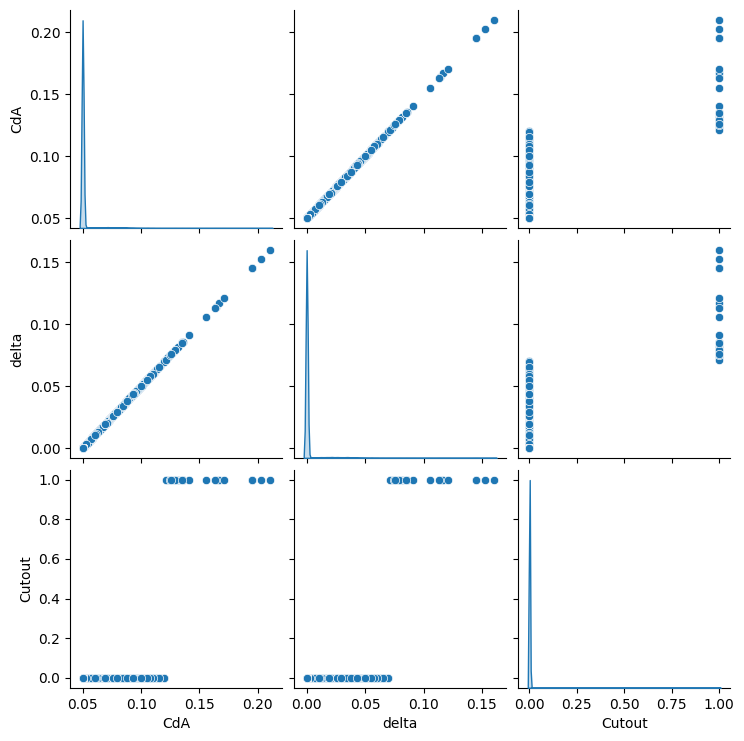

In [173]:
import seaborn as sns

sns.pairplot(df, diag_kind='kde')

In [ ]:
def ProcessVideoLite():
    pass